In [1]:
using Pkg: @pkg_str
pkg"activate ."

In [ ]:
using MLDatasets
using MLDataUtils
using Statistics
using LIBSVM
using DecisionTree
using Flux
using TensorFlow
using Plots

# FashionMNIST
https://github.com/zalandoresearch/fashion-mnist

![](https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/doc/img/fashion-mnist-sprite.png)

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |


## As a programmer, I clearly just randomly grab two items of clothing out of my wardrobe without concern for if they would leaving me appropriately covered.

I would like a ML system that looks at images of my two items of clothing,
and tells me if they are going to cover me.
That means a dress, or a top and trousers.

In [3]:
function appropriately_dressed(clothing_items...)
    3 ∈ clothing_items && return true  # A dress is both top and bottoms
    
    # need trousers and a top of some kind
    return 1 ∈ clothing_items && length(intersect(clothing_items,(0, 2, 4, 6))) > 0 
end

appropriately_dressed (generic function with 1 method)

## Generate a dataset
We are going to generate a dataset,
by taking two copies of FashionMNIST,
shuffling them, and drawing them off in pairs,
labelling each with a suitable label.

In [4]:
function generate_pants_dataset(data, max_obs=Inf)
    combination_images = Vector{Vector{Float32}}()
    is_dressed_labels = Vector{Bool}()
    for (img1, lbl1) in eachobs(shuffleobs(data)), (img2, lbl2) in eachobs(shuffleobs(data))
        push!(combination_images, [img1[:]; img2[:]])
        push!(is_dressed_labels,  appropriately_dressed(lbl1, lbl2))
        if length(is_dressed_labels) >= max_obs
            break
        end
    end
    return combination_images, is_dressed_labels
end

generate_pants_dataset (generic function with 2 methods)

In [5]:
using Random
Random.seed!(14)


train_data = generate_pants_dataset((FashionMNIST.traintensor(), FashionMNIST.trainlabels()), 20_000)
@show mean(last, eachobs(train_data))

test_data = generate_pants_dataset((FashionMNIST.testtensor(), FashionMNIST.testlabels()), 1_000);
@show mean(last, eachobs(test_data))

mean(last, eachobs(train_data)) = 0.49405
mean(last, eachobs(test_data)) = 0.489


0.489

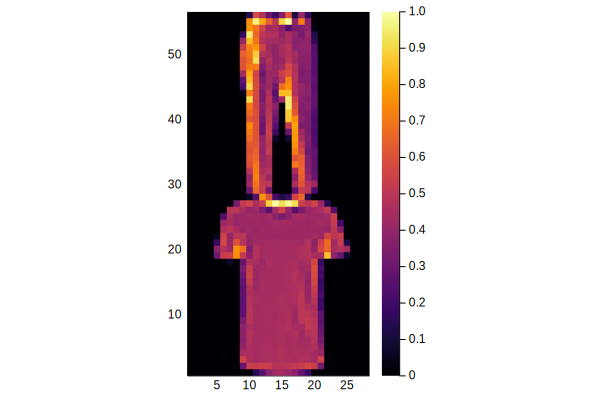

In [6]:
heatmap(rotl90(reshape(train_data[1][2], 28,:)); aspectratio=1)

# Construct a Balanced Training Set

In [7]:
balanced_train_data = undersample(last, train_data);

@show nobs(balanced_train_data)
@show mean(last, eachobs(balanced_train_data));

nobs(balanced_train_data) = 19762
mean(last, eachobs(balanced_train_data)) = 0.5


# DecisionTree

In [8]:
function demo_decision_tree(train_data, test_data)
    train_features = collect(reduce(hcat, train_data[1])')
    train_labels = collect(train_data[2])

    # train full-tree classifier
    model = build_tree(train_labels, train_features)
    # prune tree: merge leaves having >= 90% combined purity (default: 100%)
    model = prune_tree(model, 0.9)


    test_features = collect(reduce(hcat, test_data[1])')
    test_labels = collect(test_data[2]);
    classes = apply_tree(model, test_features)
    acc = mean(test_labels .== classes)
    @show acc
end

demo_decision_tree (generic function with 1 method)

In [9]:
@time demo_decision_tree(train_data, test_data)

acc = 0.972
  7.088830 seconds (6.38 M allocations: 599.668 MiB, 4.72% gc time)


0.972

In [10]:
@time demo_decision_tree(balanced_train_data, test_data)

acc = 0.974
  6.790610 seconds (5.06 M allocations: 548.854 MiB, 3.71% gc time)


0.974

## RandomForest

In [11]:
function demo_random_forest(train_data, test_data)
    train_features = collect(reduce(hcat, train_data[1])')
    train_labels = collect(train_data[2])

    model = build_forest(train_labels, train_features)

    test_features = collect(reduce(hcat, test_data[1])')
    test_labels = collect(test_data[2]);
    classes = apply_forest(model, test_features)
    acc = mean(test_labels .== classes)
    @show acc
end

demo_random_forest (generic function with 1 method)

In [12]:
@time demo_random_forest(train_data, test_data)

acc = 0.983
  4.352747 seconds (4.41 M allocations: 1.340 GiB, 19.04% gc time)


0.983

In [13]:
@time demo_random_forest(balanced_train_data, test_data)

acc = 0.983
  2.010675 seconds (134.65 k allocations: 1.093 GiB, 9.70% gc time)


0.983

# LibSVM

In [14]:
function demo_libsvm(train_data, test_data)
    train_features = reduce(hcat, train_data[1])
    train_labels = train_data[2]

    model = svmtrain(train_features, train_labels)

    test_features = reduce(hcat, test_data[1])
    test_labels = test_data[2];

    classes, probs = svmpredict(model, test_features)
    acc = mean(test_labels .== classes)
    @show acc
end



demo_libsvm (generic function with 1 method)

In [15]:
@time demo_libsvm(train_data, test_data)

acc = 0.972
344.503540 seconds (3.71 M allocations: 917.394 MiB, 0.11% gc time)


0.972

In [16]:
@time demo_libsvm(balanced_train_data, test_data)

acc = 0.971
325.684953 seconds (1.06 M allocations: 762.931 MiB, 0.05% gc time)


0.971

## TensorFlow

In [27]:
function tensorflow_model(in_size = 1568)
    sess = Session(Graph())

    leaky_relu6(x) = 0.01x + nn.relu6(x)

    # Network Definition
    @tf begin
        X = placeholder(Float32, shape=[-1, in_size])

        # Network parameters
        hl_sizes = [512, 128, 64]

        Zs = [X]
        for (ii, hlsize) in enumerate(hl_sizes)
            Wii = get_variable("W_$ii", [get_shape(Zs[end], 2), hlsize], Float32)
            bii = get_variable("b_$ii", [hlsize], Float32)
            Zii = leaky_relu6(Zs[end]*Wii + bii)
            push!(Zs, Zii)
        end

        Wout = get_variable([get_shape(Zs[end], 2), 1], Float32)
        bout = get_variable([1], Float32)
        Y_logits = Zs[end]*Wout + bout
        
        Y_mat = nn.sigmoid(Y_logits)
        Y_pred = dropdims(Y_mat; dims=[2]) #drop first dimention
        
        Y_target = placeholder(Float32, shape=[-1])
        loss = nn.sigmoid_cross_entropy_with_logits(;logits=Y_pred, targets=Y_target)
        mean_loss = mean(loss)
        optimizer = TensorFlow.train.minimize(train.AdamOptimizer(), loss)
    end 
    run(sess, global_variables_initializer())

    return (sess, optimizer)
end

function demo_tf(train_data, test_data)
    sess, opt = tensorflow_model()
    
    train_features = reduce(hcat, train_data[1])'
    train_labels = train_data[2]
    
    for epoch in 1:50
        run(sess, opt, Dict(
            sess.graph["X"] => train_features,
            sess.graph["Y_target"] => train_labels
        ))
    end

    test_features = collect(reduce(hcat, test_data[1])')
    test_labels = collect(test_data[2]);
    
    classes = run(sess, sess.graph["Y_pred"] > 0.5, Dict(
            sess.graph["X"] => test_features
        ))
    @show mean(classes)
    acc = mean(test_labels .== classes)
    @show acc
end



demo_tf (generic function with 1 method)

In [30]:
@time demo_tf(train_data, test_data)

mean(classes) = 0.486
acc = 0.963
 57.732387 seconds (6.90 M allocations: 12.283 GiB, 2.37% gc time)


0.963

In [31]:
@time demo_tf(balanced_train_data, test_data)

mean(classes) = 0.481
acc = 0.96
 63.206049 seconds (7.03 M allocations: 12.148 GiB, 2.35% gc time)


0.96

# Flux

In [20]:
function flux_model(in_size = 1568)
    leaky_relu6(x) = oftype(x/1, 0.01f0)*x + clamp(x, 0, 6)

    return Chain(
        Dense(in_size, 512, leaky_relu6), 
        Dense(512, 128, leaky_relu6),
        Dense(128, 64, leaky_relu6), 
        Dense(64, 1),
        vec
    )
    
end

function demo_flux(train_data, test_data)
    mdl = flux_model()
    
    features = reduce(hcat, first(train_data))
    labels = Float32.(last(train_data))
    
    Flux.train!(
        params(mdl),
        Iterators.repeated((features, labels), 50), # 50 epochs
        Flux.ADAM()
    ) do xs, ys # This block repressents 1 epochs
        mean(Flux.logitbinarycrossentropy.(mdl(xs), ys))
    end
    
    test_features, test_labels = test_data
    
    probs = map(first∘Flux.data∘mdl, test_features)
    classes = probs .> 0
    @show mean(classes)
    acc = mean(test_labels .== classes)
    @show acc
end

demo_flux (generic function with 1 method)

In [23]:
@time demo_flux(train_data, test_data)

mean(classes) = 0.488
acc = 0.983
 43.096371 seconds (148.81 k allocations: 19.618 GiB, 39.97% gc time)


0.983

In [24]:
@time demo_flux(balanced_train_data, test_data)

mean(classes) = 0.49
acc = 0.983
 43.991950 seconds (148.81 k allocations: 19.390 GiB, 40.20% gc time)


0.983